## Recordings segments loader

In [1]:
import os
import json
from functools import reduce

# is_single_speaker_segment [VALIDATED]
# validates if a segment has a single speaker who belongs to the speakers list. 
def is_single_speaker_segment(segment, valid_speakers_ids = ['A', 'B']):
    return len(segment['speakers']) == 1 and segment['speakers'][0]['speaker_id'] in valid_speakers_ids

# is_valid_segment [VALIDATED]
# validates if a segment meets a maximum number of speakers,
# and that all the speakers in the segment belong to a list.
def is_valid_segment(segment, maximum_speakers_length = 2, valid_speakers_ids = ['A', 'B']):
    speakers_ids = [speaker['speaker_id'] for speaker in segment['speakers']]
    speakers_ids = list(set(speakers_ids))
    return len(speakers_ids) <= maximum_speakers_length and \
        all(speaker_id in valid_speakers_ids for speaker_id in speakers_ids)

# load_recordings_segments [VALIDATED]
# loads the recordings segments data from the .json files located in a directory 
def load_recordings_segments(directory, validation_function):
    filenames = [filename for filename in os.listdir(directory) if os.path.isfile(os.path.join(directory, filename))]
    filenames.sort()
    recordings_segments = {}
    recordings_length = len(filenames)
    recordings_count = 0
    segments_original = 0
    segments_filtered = 0
    for filename in filenames:
        recording_id = filename.split('.')[0]
        filepath = os.path.join(directory, filename)
        file = open(filepath, 'r')
        recordings_segments[recording_id] = [json.loads(line) for line in file.readlines()]
        file.close()
        segments_original += len(recordings_segments[recording_id])
        recordings_segments[recording_id] = list(filter(validation_function, recordings_segments[recording_id]))
        segments_filtered += len(recordings_segments[recording_id])
        recordings_count += 1
        print(directory + ' loading ' + str(recordings_count) + '/' + str(recordings_length), end = '\r')
    print(directory, 'loaded', str(recordings_count) + '/' + str(recordings_length) + ',', round(segments_filtered / segments_original, 2), 'segments left.')
    return recordings_segments

# speakers_get_indexes [VALIDATED]
# used to convert a (speakers_ids, index) list to a speakers_ids => [indexes] dictionary
def speakers_get_indexes(accumulator, speakers_tuple):
    speaker_ids, index = speakers_tuple
    speaker_ids = ','.join(speaker_ids)
    if speaker_ids in accumulator:
        accumulator[speaker_ids].append(index)
    else:
        accumulator[speaker_ids] = [index]
    return accumulator

# balance_segments [VALIDATED]
# balances the recording segments data to meet a minimum of speakers per recording,
# and a minimum of segments per speaker.
def balance_segments(recordings_segments,
                     minimum_speakers_length = 2,
                     minimum_speaker_segments = 3,
                     include_overlaps = False):
    new_recordings_segments = {}
    for recording_id in recordings_segments:
        recording_segments = recordings_segments[recording_id]
        # ----- Obtaining speakers indexes ----- #
        speakers_indexes = [(sorted(list(set([speaker['speaker_id'] for speaker in segment['speakers']]))), index) for index, segment in enumerate(recording_segments)]
        speakers_indexes = reduce(speakers_get_indexes, speakers_indexes, {})
        # ----- Removing overlaps ----- #
        if not include_overlaps:
            for speakers_ids in list(speakers_indexes.keys()):
                if len(speakers_ids.split(',')) > 1:
                    del speakers_indexes[speakers_ids]
        speakers_lengths = [(speakers_ids, len(speakers_indexes[speakers_ids])) for speakers_ids in speakers_indexes]
        speakers_lengths.sort(key = lambda x: x[1])
        speakers_lengths_min = speakers_lengths[0][1]
        if len(speakers_lengths) >= minimum_speakers_length and speakers_lengths_min >= minimum_speaker_segments:
            recording_indexes = []
            for speakers_ids in speakers_indexes:
                speakers_indexes[speakers_ids] = speakers_indexes[speakers_ids][:speakers_lengths_min]
                recording_indexes += speakers_indexes[speakers_ids]
            new_recordings_segments[recording_id] = [segment for index, segment in enumerate(recordings_segments[recording_id]) if index in recording_indexes]
    print('Recordings left: ' + str(len(new_recordings_segments)) + '/' + str(len(recordings_segments)))
    return new_recordings_segments

## Recordings dataset

In [2]:
from torch.utils.data import Dataset
import random
import numpy as np
import itertools

def generate_speaker_model(speakers_segments_indexes,
                           recordings_segments,
                           segments_length,
                           vector = 'ivectors',
                           selection = 'first',
                           indexes = []):
    if selection == 'first':
        selected_segments = [recordings_segments[recording_id][index] for recording_id, index, real in speakers_segments_indexes[:segments_length]]
    elif selection == 'random':
        selected_segments = [recordings_segments[recording_id][index] for recording_id, index, real in random.sample(speakers_segments_indexes, segments_length if segments_length < len(speakers_segments_indexes) else len(speakers_segments_indexes))]
    else:
        print('ERROR: unknown speaker model segments selection strategy.')
    selected_vectors = [np.asarray(segment[vector][0]['value']) for segment in selected_segments]
    return np.sum(selected_vectors, 0) / len(selected_vectors)

def get_speakers_segments_indexes(acc, recording_id_index_real, recordings_segments):
    recording_id, index, real = recording_id_index_real
    segment = recordings_segments[recording_id][index]
    speakers_ids = ','.join(sorted([speaker['speaker_id'] for speaker in segment['speakers']]))
    if speakers_ids not in acc:
        acc[speakers_ids] = []
    acc[speakers_ids].append(recording_id_index_real)
    return acc

class Recordings_dataset(Dataset):
    def __init__(self,
                 recordings_segments,
                 recordings_ids = None,
                 vector = 'ivectors',
                 models_container_length = 2,
                 models_container_include_zeros = True,
                 models_container_include_overlaps = False,
                 models_generation_lengths = [3],
                 models_generation_selection = 'first',
                 include_false_segments = 'models'):
        # ----- Saving the recordings ids ----- #
        if recordings_ids is None:
            recordings_ids = [recording_id for recording_id in recordings_segments]
        self.recordings_ids = recordings_ids if isinstance(recordings_ids, list) else [recordings_ids] 
        # ----- Saving the recordings segments ----- #
        self.recordings_segments = recordings_segments
        # ----- Saving the arguments ----- #
        self.vector = vector
        self.models_container_length = models_container_length
        self.models_container_include_zeros = models_container_include_zeros
        self.models_container_include_overlaps = models_container_include_overlaps
        self.models_generation_lengths = models_generation_lengths
        self.models_generation_selection = models_generation_selection
        self.include_false_segments = include_false_segments
        
        self.recordings_data = {}
        self.recordings_models = {}
        
        # ----- Initializing the recordings data ----- #
        for recording_id in self.recordings_ids:
            self.recordings_data[recording_id] = {}
        
        # ----- Saving the recordings segments indexes ----- #
        for recording_id in self.recordings_data:
            recording_data = self.recordings_data[recording_id]
            recording_data['recording_segments_indexes'] = [(recording_id, index, True) for index, segment in enumerate(self.recordings_segments[recording_id])]
            
        # ----- Obtaining the recordings speakers segments indexes ----- #
        for recording_id in self.recordings_data:
            recording_data = self.recordings_data[recording_id]
            recording_data['speakers_segments_indexes'] = reduce(lambda acc, recording_id_index_real: get_speakers_segments_indexes(acc, recording_id_index_real, self.recordings_segments), recording_data['recording_segments_indexes'], {})
            # ----- Obtaining the max speaker segments length ----- #
            recording_data['speakers_segments_indexes_lengths_max'] = max([len(recording_data['speakers_segments_indexes'][speakers_ids]) for speakers_ids in recording_data['speakers_segments_indexes']])
      
        # ----- Generating the recordings speakers models ----- #
        for recording_id in self.recordings_data:
            self.recordings_models[recording_id] = []
            recording_data = self.recordings_data[recording_id]
            recording_data['speakers_models'] = {}
            for speakers_ids in recording_data['speakers_segments_indexes']:
                recording_data['speakers_models'][speakers_ids] = {}
                for models_generation_length in models_generation_lengths:
                    speakers_model = generate_speaker_model(recording_data['speakers_segments_indexes'][speakers_ids], self.recordings_segments, models_generation_length, self.vector, self.models_generation_selection)
                    model_segment = {}
                    model_segment[vector] = [{ 'value': speakers_model }]
                    model_segment['speakers'] = [{ 'speaker_id': speakers_ids }]
                    self.recordings_models[recording_id].append(model_segment)
                    recording_data['speakers_models'][speakers_ids][models_generation_length] = [speakers_model]
        
        # ----- Generating the recordings speakers models permutations ----- #
        for recording_id in self.recordings_data:
            recording_data = self.recordings_data[recording_id]
            if self.models_container_include_zeros:
                recording_data['permutations'] = list(itertools.permutations(list(recording_data['speakers_models'].keys()) + ['0' for _ in range(self.models_container_length)], self.models_container_length))
            else:
                recording_data['permutations'] = list(itertools.permutations(list(recording_data['speakers_models'].keys()), self.models_container_length))
            recording_data['permutations'] = sorted(set(recording_data['permutations']))
            if not self.models_container_include_overlaps:
                recording_data['permutations'] = [permutation for permutation in recording_data['permutations'] if all(len(speakers_ids.split(',')) == 1 for speakers_ids in permutation)]

        # ----- Generatign false segments ----- #
        if self.include_false_segments == 'segments':
            for recording_id in self.recordings_data:
                recording_data = self.recordings_data[recording_id]
                other_recordings_segments_indexes = []
                for other_recording_id in self.recordings_segments:
                    if other_recording_id != recording_id:
                        other_recordings_segments_indexes += [(other_recording_id, index, False) for index, segment in enumerate(self.recordings_segments[other_recording_id])]
                if len(other_recordings_segments_indexes) >= recording_data['speakers_segments_indexes_lengths_max']:
                    other_recordings_segments_indexes = random.sample(other_recordings_segments_indexes, recording_data['speakers_segments_indexes_lengths_max'])
                    options = [recording_data['recording_segments_indexes'], other_recordings_segments_indexes]
                    options_lengths = [len(option) for option in options]
                    new_recording_segments_indexes = []
                    while sum(options_lengths) > 0:
                        options_indexes = list(itertools.chain(*[[index] * len(option) for index, option in enumerate(options)]))
                        option_index = random.choice(options_indexes)
                        new_recording_segments_indexes.append(options[option_index].pop(0))
                        options_lengths = [len(option) for option in options]
                    recording_data['recording_segments_indexes'] = new_recording_segments_indexes
        elif self.include_false_segments == 'models':
            for recording_id in self.recordings_data:
                recording_data = self.recordings_data[recording_id]
                other_recordings_segments_indexes = []
                for other_recording_id in self.recordings_models:
                    if other_recording_id != recording_id:
                        other_recordings_segments_indexes += [(other_recording_id, index, False) for index, segment in enumerate(self.recordings_models[other_recording_id])]
                other_recordings_segments_indexes = random.sample(other_recordings_segments_indexes, int(0.5 * recording_data['speakers_segments_indexes_lengths_max'] if recording_data['speakers_segments_indexes_lengths_max'] < len(other_recordings_segments_indexes) else len(other_recordings_segments_indexes)))
                
                options = [recording_data['recording_segments_indexes'], other_recordings_segments_indexes]
                options_lengths = [len(option) for option in options]
                new_recording_segments_indexes = []
                while sum(options_lengths) > 0:
                    options_indexes = list(itertools.chain(*[[index] * len(option) for index, option in enumerate(options)]))
                    option_index = random.choice(options_indexes)
                    new_recording_segments_indexes.append(options[option_index].pop(0))
                    options_lengths = [len(option) for option in options]
                recording_data['recording_segments_indexes'] = new_recording_segments_indexes
                
        # ----- Obtaining the dataset length ----- #
        self.recordings_length = 0
        self.recordings_map = []
        for recording_id in self.recordings_data:
            recording_data = self.recordings_data[recording_id]
            recording_data['permutations_map'] = []
            recording_data['permutations_length'] = 0
            for index, permutation in enumerate(recording_data['permutations']):
                speakers_models_length = int(np.prod([np.sum([len(recording_data['speakers_models'][speakers_ids][models_generation_length]) for models_generation_length in recording_data['speakers_models'][speakers_ids]]) for speakers_ids in permutation if speakers_ids != '0']))
                recording_data['permutations_map'].append((recording_data['permutations_length'], recording_data['permutations_length'] + speakers_models_length - 1, index))
                recording_data['permutations_length'] += speakers_models_length
            recording_data['length'] = len(recording_data['recording_segments_indexes']) * recording_data['permutations_length']
            self.recordings_map.append((self.recordings_length, self.recordings_length + recording_data['length'] - 1, recording_id))
            self.recordings_length += recording_data['length']
    def __len__(self):
        return self.recordings_length
    def __getitem__(self, idx):
        recording_limits = list(filter(lambda recording_limits: recording_limits[0] <= idx and idx <= recording_limits[1], self.recordings_map))[0]
        recording_idx = idx - recording_limits[0]
        recording_id = recording_limits[2]
        recording_data = self.recordings_data[recording_id]
        
        segment_id, segment_idx = divmod(recording_idx, recording_data['permutations_length'])
        segment_recording_id, segment_index, segment_real = recording_data['recording_segments_indexes'][segment_id]
        if not segment_real and self.include_false_segments == 'models':
            segment = self.recordings_models[segment_recording_id][segment_index]
        else:
            segment = self.recordings_segments[segment_recording_id][segment_index]
        vector = np.asarray(segment[self.vector][0]['value'])
        
        permutation_limits = list(filter(lambda permutation_limits: permutation_limits[0] <= segment_idx and segment_idx <= permutation_limits[1], recording_data['permutations_map']))[0]
        permutation_idx = segment_idx - permutation_limits[0]
        permutation_index = permutation_limits[2]
        permutation = recording_data['permutations'][permutation_index]
        
        speakers_models_lengths = [np.sum([len(recording_data['speakers_models'][speakers_ids][models_generation_length]) for models_generation_length in recording_data['speakers_models'][speakers_ids]])  if speakers_ids != '0' else 1 for speakers_ids in permutation]
        models_container = []
        model_index = permutation_idx
        for i, length_i in enumerate(speakers_models_lengths):
            if i != len(speakers_models_lengths) - 1:
                model_index, remainder = divmod(model_index, np.sum(speakers_models_lengths[i + 1:]))
            else:
                model_index = remainder
            models_container.append(recording_data['speakers_models'][permutation[i]][self.models_generation_lengths[model_index]][0] if permutation[i] != '0' else np.random.uniform(-0.1, 0.1, len(vector)))
        
        models_weigths = np.asarray([len(recording_data['speakers_segments_indexes'][speakers_ids]) if speakers_ids != '0' else recording_data['speakers_segments_indexes_lengths_max'] for speakers_ids in permutation])
        models_weigths_sum = np.sum(models_weigths)
        models_weigths = np.ones(len(models_weigths)) - models_weigths / models_weigths_sum
        
        targets_ids = [speaker['speaker_id'] for speaker in segment['speakers']]
        
        x = [vector] + models_container
        if segment_real:
            if self.models_container_include_overlaps:
                targets_ids = ','.join(sorted(list(set(targets_ids))))
                y = np.asarray([speakers_ids == targets_ids for speakers_ids in permutation], dtype = float)
            else:
                y = np.asarray([speaker_id in targets_ids for speaker_id in permutation], dtype = float) / len(targets_ids)
        else:
            y = np.zeros(len(permutation))
        z = models_weigths

        return x, y, z, segment_real

## Live plotter

In [3]:
# %load live_graph.py
%matplotlib notebook
import matplotlib.pyplot as plt

class Live_graph:
    def __init__(self, validation_threshold):
        self.plt_count = -1
        self.validation_threshold = validation_threshold
        self.plt_thr = ([self.plt_count], [self.validation_threshold])
        self.plt_loss = ([self.plt_count], [1])
        self.plt_valid = ([self.plt_count], [1])
        self.plt_test = ([self.plt_count], [1])
        self.fig = plt.figure()
        self.ax = self.fig.add_subplot()
        self.line0, = self.ax.plot(self.plt_thr[0], self.plt_thr[1], 'k--', label = 'Threshold') # Threshold line
        self.line1, = self.ax.plot(self.plt_loss[0], self.plt_loss[1], '--', label = 'Training') # Training loss
        self.line2, = self.ax.plot(self.plt_valid[0], self.plt_valid[1], label = 'Validation')   # Validation loss
        self.line3, = self.ax.plot(self.plt_test[0], self.plt_test[1], label = 'Test')           # Test loss
        self.ax.set_xlabel('Epoch')
        self.ax.set_ylabel('Loss')
        self.ax.legend()
        self.ax.set_xlim(-1, 0)
        self.ax.set_ylim(0, 0.5)
        self.fig.canvas.draw()
        self.fig.canvas.flush_events()
    def step(self, training, validation, test = -1):
        self.plt_count += 1
        self.plt_thr[0].append(self.plt_count)
        self.plt_thr[1].append(self.validation_threshold)
        self.plt_loss[0].append(self.plt_count)
        self.plt_loss[1].append(training)
        self.plt_valid[0].append(self.plt_count)
        self.plt_valid[1].append(validation)
        self.plt_test[0].append(self.plt_count)
        self.plt_test[1].append(test)
        self.line0.set_xdata(self.plt_thr[0])
        self.line0.set_ydata(self.plt_thr[1])
        self.line1.set_xdata(self.plt_loss[0])
        self.line1.set_ydata(self.plt_loss[1])
        self.line2.set_xdata(self.plt_valid[0])
        self.line2.set_ydata(self.plt_valid[1])
        self.line3.set_xdata(self.plt_test[0])
        self.line3.set_ydata(self.plt_test[1])
        self.ax.set_xlim(0, self.plt_count + 1)
        self.fig.canvas.draw()
        self.fig.canvas.flush_events()

## DNN model

In [4]:
import torch.nn as nn

class Net(nn.Module):
    def __init__(self, models_container_length, vector_length):
        super().__init__()
        n = models_container_length
        m = vector_length
        self.cnn1 = nn.Sequential(
            nn.Conv1d((n + 1), n ** 3, 3),
            nn.ReLU(),
            nn.Conv1d(n ** 3, n ** 2, 3),
            nn.ReLU(),
            nn.Conv1d(n ** 2, n, 3),
            nn.ReLU(),
        )
        self.lstm1 = nn.Sequential(
            nn.LSTM(m - 6, 32, bidirectional = True),
        )
        self.fc1 = nn.Sequential(
            nn.Linear(n * 2 * 32, 32),
            nn.ReLU(),
            nn.Linear(32, n),
            nn.Sigmoid(),
        )
        
    def forward(self, input):
        x = torch.stack(input, 1)
        x = self.cnn1(x)
        x, _ = self.lstm1(x)
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        return x

## DNN trainer

In [5]:
import torch
from torch.utils.data import DataLoader, random_split
import torch.optim as optim

class Trainer:
    def __init__(self):
        if torch.cuda.is_available():
            self.device = torch.device('cuda:0')
        else:
            self.device = torch.device('cpu')
    def get_net(self,
                recordings_segments,
                recordings_ids = None,
                vector = 'ivectors',
                vector_length = 128,
                models_container_length = 2,
                models_container_include_zeros = True,
                models_container_include_overlaps = False,
                models_generation_lengths = [3],
                models_generation_selection = 'first',
                balance_segments = True,
                balance_segments_selection = 'copy',
                batch_size = 16,
                num_workers = 8,
                test_recordings_segments = None):
        
        if recordings_ids is None:
            recordings_ids = [recording_id for recording_id in recordings_segments]
        self.recordings_ids = recordings_ids if isinstance(recordings_ids, list) else [recordings_ids]
        
        train_length = int(len(self.recordings_ids) * 0.7)
        valid_length = len(self.recordings_ids) - train_length
        
        valid_recordings_ids = sorted(random.sample(self.recordings_ids, valid_length))
        train_recordings_ids = [recording_id for recording_id in self.recordings_ids if recording_id not in valid_recordings_ids]

        train_dataset = Recordings_dataset(recordings_segments,
                                           train_recordings_ids, 
                                           vector,
                                           models_container_length,
                                           models_container_include_zeros,
                                           models_container_include_overlaps,
                                           models_generation_lengths,
                                           models_generation_selection)
        
        valid_dataset = Recordings_dataset(recordings_segments,
                                           valid_recordings_ids, 
                                           vector,
                                           models_container_length,
                                           models_container_include_zeros,
                                           models_container_include_overlaps,
                                           models_generation_lengths,
                                           models_generation_selection)

        train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=False, num_workers = num_workers)
        valid_dataloader = DataLoader(valid_dataset, batch_size = batch_size, shuffle=False, num_workers = num_workers)
        
        if test_recordings_segments is not None:
            test_recordings_ids = [recording_id for recording_id in test_recordings_segments]
            test_dataset = Recordings_dataset(test_recordings_segments,
                                              test_recordings_ids,
                                              vector,
                                              models_container_length,
                                              models_container_include_zeros,
                                              models_container_include_overlaps,
                                              models_generation_lengths,
                                              models_generation_selection)
            test_dataloader = DataLoader(test_dataset, batch_size = batch_size, num_workers = num_workers)

        net = Net(models_container_length, vector_length).to(self.device)
        optimizer = optim.Adam(net.parameters(), lr = 0.0001)

        epochs = 20
        validation_threshold = 0.03

        live_graph = Live_graph(validation_threshold)

        for epoch in range(epochs):
            train_losses = []
            for input, target, weigth, segment_real in train_dataloader:
                input = [tensor.to(self.device, non_blocking = True).float() for tensor in input]
                target = target.to(self.device, non_blocking = True).float()
                weigth = weigth.to(self.device, non_blocking = True).float()

                criterion = nn.BCELoss(weigth)
                net.zero_grad()
                output = net(input)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()

                train_losses.append(loss.data)
                print('train: ' + str(len(train_losses)) + '/' + str(len(train_dataloader)) + '          ', end = '\r')
            train_loss = np.sum(train_losses) / len(train_losses)

            with torch.no_grad():
                validation_losses = []
                for input, target, weigth, segment_real in valid_dataloader:
                    input = [tensor.to(self.device, non_blocking = True).float() for tensor in input]
                    target = target.to(self.device, non_blocking = True).float()
                    weigth = weigth.to(self.device, non_blocking = True).float()

                    criterion = nn.BCELoss(weigth)
                    output = net(input)
                    loss = criterion(output, target)
                    validation_losses.append(loss.data)
                    print('validation: ' + str(len(validation_losses)) + '/' + str(len(valid_dataloader)) + '          ', end = '\r')
                validation_loss = np.sum(validation_losses) / len(validation_losses)
                
                test_loss = -1
                if test_recordings_segments is not None:
                    test_losses = []
                    for input, target, weigth in test_dataloader:
                        input = [tensor.to(self.device, non_blocking = True).float() for tensor in input]
                        target = target.to(self.device, non_blocking = True).float()
                        weigth = weigth.to(self.device, non_blocking = True).float()

                        criterion = nn.BCELoss(weigth)
                        output = net(input)
                        loss = criterion(output, target)
                        test_losses.append(loss.data)
                        print('test: ' + str(len(test_losses)) + '/' + str(len(test_dataloader)) + '          ', end = '\r')
                    test_loss = np.sum(test_losses) / len(test_losses)

            live_graph.step(train_loss, validation_loss, test_loss)

            if validation_loss <= validation_threshold:
                print('Done training.')
                break
        return net

## Tracking tester

In [6]:
import copy
import kaldi_utils

def tracking_tester(recordings_segments,
                    recordings_ids = None,
                    scoring_function = None,
                    groundtruth_filepath = '',
                    groundtruth_valid_speakers_ids = ['A', 'B'],
                    vector = 'ivectors',
                    models_container_length = 2,
                    models_container_include_overlaps = False,
                    models_generation_length = 3,
                    models_generation_selection = 'first',
                    save_dir = 'tmp'):

    if recordings_ids is None:
        recordings_ids = [recording_id for recording_id in recordings_segments]
    recordings_ids = recordings_ids if isinstance(recordings_ids, list) else [recordings_ids]
    recordings_ids.sort()
    
    results = {}
    results_reduced = {}
    results_rttm = ''
    results_scores = {}
    eer_scores = ''
    dcf_scores = ''
    dcf_trials = ''
    for i, recording_id in enumerate(recordings_ids):
        print('tracking running: recording ' + str(i + 1) + '/' + str(len(recordings_ids)), end = '\r')
        # ----- Generating the models of each speaker in this recording ----- #
        recording_dataset = Recordings_dataset(recordings_segments,
                                               recording_id,
                                               vector = vector,
                                               models_container_length = models_container_length,
                                               models_container_include_zeros = False,
                                               models_container_include_overlaps = models_container_include_overlaps,
                                               models_generation_lengths = [models_generation_length],
                                               models_generation_selection = models_generation_selection)
        speakers_models = recording_dataset.recordings_data[recording_id]['speakers_models']
        speakers_segments_indexes_lengths_max = recording_dataset.recordings_data[recording_id]['speakers_segments_indexes_lengths_max']
        speakers_ids = [speakers_ids for speakers_ids in speakers_models]
        models_container = [speakers_models[speakers_ids][models_generation_length][0] for speakers_ids in speakers_models if models_container_include_overlaps or len(speakers_ids.split(',')) == 1]
        # ----- Filling with 0's the remaining spaces of the speaker's models container ----- #
        for i in range(models_container_length - len(models_container)):
            models_container.append(np.random.uniform(-0.1, 0.1, len(models_container[0])))
            
        # ----- Obtaining the recording segments indexes ----- #
        recording_segments_indexes = [(recording_id, index, True) for index, segment, in enumerate(recordings_segments[recording_id])]
        
        # ----- Generating the false segments indexes ----- #
        other_recordings_segments = {}
        other_recordings_segments_indexes = []
        
        for other_recording_id in recordings_segments:
            if other_recording_id != recording_id:
                other_recordings_segments[other_recording_id] = []
                #other_recordings_segments_indexes += [(other_recording_id, index, False) for index, segment in enumerate(recordings_segments[other_recording_id])]
                other_dataset = Recordings_dataset(recordings_segments,
                                                   other_recording_id,
                                                   vector = vector,
                                                   models_container_length = models_container_length,
                                                   models_container_include_zeros = False,
                                                   models_container_include_overlaps = models_container_include_overlaps,
                                                   models_generation_lengths = [models_generation_length],
                                                   models_generation_selection = models_generation_selection)
                other_speakers_models = other_dataset.recordings_data[other_recording_id]['speakers_models']
                other_speakers_segments = [other_dataset.recordings_data[other_recording_id]['speakers_segments_indexes'][speakers_ids][0] for speakers_ids in other_speakers_models]
                other_speakers_segments = [copy.deepcopy(recordings_segments[segment_recording_id][segment_index]) for segment_recording_id, segment_index, segment_real in other_speakers_segments]
                other_speakers_models = [other_speakers_models[speakers_ids][models_generation_length][0] for speakers_ids in other_speakers_models]
                for index, segment in enumerate(other_speakers_segments):
                    other_speakers_segments[index][vector][0]['value'] = other_speakers_models[index]
                    other_recordings_segments[other_recording_id].append(other_speakers_segments[index])
                    other_recordings_segments_indexes.append((other_recording_id, len(other_recordings_segments[other_recording_id]) - 1, False))                

        #other_recordings_segments_indexes = random.sample(other_recordings_segments_indexes, speakers_segments_indexes_lengths_max if speakers_segments_indexes_lengths_max < len(other_recordings_segments_indexes) else len(other_recordings_segments_indexes))    
        options = [recording_segments_indexes, other_recordings_segments_indexes]
        options_lengths = [len(option) for option in options]
        new_recording_segments_indexes = []
        while sum(options_lengths) > 0:
            options_indexes = list(itertools.chain(*[[index] * len(option) for index, option in enumerate(options)]))
            option_index = random.choice(options_indexes)
            new_recording_segments_indexes.append(options[option_index].pop(0))
            options_lengths = [len(option) for option in options]
        recording_segments_indexes = new_recording_segments_indexes
        
        # ----- Obtaining the recording tracking results ----- #
        results[recording_id] = []
        results_scores[recording_id] = []
        for segment_recording_id, segment_index, segment_real in recording_segments_indexes:
            #segment = recordings_segments[segment_recording_id][segment_index]
            if segment_real:
                segment = recordings_segments[segment_recording_id][segment_index]
            else:
                segment = other_recordings_segments[segment_recording_id][segment_index]
            segment_vector = np.asarray(segment[vector][0]['value'])
            segment_vector_id = segment[vector][0]['ivector_id' if vector == 'ivectors' else 'xvector_id']
            
            scores = scoring_function(segment_vector, models_container)
            
            targets_ids = sorted([speaker['speaker_id'] for speaker in segment['speakers']])
            labels = ['target' if segment_real and targets_ids == sorted(speaker_id.split(',')) else 'nontarget' for speaker_id in speakers_ids]
            
            utterances = [recording_id + '_' + speaker_id for speaker_id in speakers_ids]
            
            # utt1, utt2, score, target/nontarget
            scores_labels = list(zip([segment_vector_id for speaker_id in speakers_ids], utterances, labels, scores))
            results_scores[recording_id].append(scores_labels)
            
            if segment_real:
                index = np.argmax(scores)
                results[recording_id].append({ 'begining': segment['begining'], 'ending': segment['ending'], 'speaker_id': index })
                if len(results[recording_id]) > 2:
                    if results[recording_id][len(results[recording_id]) - 1]['speaker_id'] == results[recording_id][len(results[recording_id]) - 3]['speaker_id']:
                        if results[recording_id][len(results[recording_id]) - 1]['speaker_id'] != results[recording_id][len(results[recording_id]) - 2]['speaker_id']:
                            results[recording_id][len(results[recording_id]) - 2]['speaker_id'] = results[recording_id][len(results[recording_id]) - 1]['speaker_id']
                            results[recording_id][len(results[recording_id]) - 1]['modified'] = True
        results_reduced[recording_id] = []
        last_speaker_id = -1
        last_speaker = { 'begining': 0, 'ending': 0, 'speaker_id': -1 }
        for segment in results[recording_id] + [{ 'begining': 0, 'ending': 0, 'speaker_id': -1 }]:
            begining = segment['begining']
            ending = segment['ending']
            speaker_id = segment['speaker_id']
            if last_speaker_id != speaker_id:
                if last_speaker_id != -1:
                    results_reduced[recording_id].append(last_speaker)
                last_speaker_id = speaker_id
                last_speaker = { 'begining': begining, 'ending': ending, 'speaker_id': speaker_id }
            else:
                if begining <= last_speaker['ending']:
                    last_speaker['ending'] = ending
                else:
                    if last_speaker_id != -1:
                        results_reduced[recording_id].append(last_speaker)
                    last_speaker_id = speaker_id
                    last_speaker = { 'begining': begining, 'ending': ending, 'speaker_id': speaker_id }
        for scores_labels in results_scores[recording_id]:
            for score_label in scores_labels:
                # ('iaab_000-00000000-00000099', 'iaab_B', 'target', 0.9978078)
                eer_score = '{:f}'.format(score_label[3]) + ' ' + score_label[2]
                eer_scores += eer_score + '\n'
                dcf_score = score_label[0] + ' ' + score_label[1] + ' ' + '{:f}'.format(score_label[3])
                dcf_scores += dcf_score + '\n'
                dcf_trial = score_label[0] + ' ' + score_label[1] + ' '+ score_label[2]
                dcf_trials += dcf_trial + '\n'
        for segment in results_reduced[recording_id]:
            result_rttm = 'SPEAKER ' + recording_id + ' 0 ' + str(segment['begining']) + ' ' + str(round(segment['ending'] - segment['begining'], 2)) + ' <NA> <NA> ' + str(segment['speaker_id']) + ' <NA> <NA>'
            results_rttm += result_rttm + '\n'
    print('traking done: recording', str(i + 1) + '/' + str(len(recordings_ids)), '          ')

    file = open(groundtruth_filepath, 'r')
    groundtruth_rttm = ''.join([line for line in file.readlines() if (line.split(' ')[1] in recordings_ids) and \
                    (line.split(' ')[7] in groundtruth_valid_speakers_ids)])
    file.close()
    
    !mkdir -p $save_dir
    
    file = open(save_dir + '/eer.scores', 'w')
    file.write(eer_scores)
    file.close()
    
    file = open(save_dir + '/dcf.scores', 'w')
    file.write(dcf_scores)
    file.close()
    
    file = open(save_dir + '/dcf.trials', 'w')
    file.write(dcf_trials)
    file.close()
    
    file = open(save_dir + '/groundtruth.rttm', 'w')
    file.write(groundtruth_rttm)
    file.close()
    
    file = open(save_dir + '/results.rttm', 'w')
    file.write(results_rttm)
    file.close()
    
    output_der = kaldi_utils.md_eval(save_dir + '/groundtruth.rttm', save_dir + '/results.rttm', log_directory=save_dir)
    output_eer = kaldi_utils.compute_eer(save_dir + '/eer.scores', log_directory=save_dir)
    output_dcf = kaldi_utils.compute_min_dcf(save_dir + '/dcf.scores', save_dir + '/dcf.trials', log_directory=save_dir)

    return { 'der': output_der, 'eer': output_eer, 'dcf': output_dcf }

## Loading recordings segments

In [7]:
a_directory = '../exp/augmented5/callhome1/json'
a_groundtruth = '../exp/augmented5/callhome1/segments_augmented_1.0_0.5_ABZ.rttm'
b_directory = '../exp/augmented5/callhome2/json'
b_groundtruth = '../exp/augmented5/callhome2/segments_augmented_1.0_0.5_ABZ.rttm'
maximum_speakers_length = 1
valid_speakers_ids = ['A', 'B']
models_container_length = 2
models_container_include_zeros = True
models_container_include_overlaps = False
models_generation_selection = 'first'
balance_segments_selection = 'copy'
batch_size = 32

In [8]:
a_recordings_segments = load_recordings_segments(a_directory,
  lambda segment: is_valid_segment(segment, maximum_speakers_length, valid_speakers_ids))
b_recordings_segments = load_recordings_segments(b_directory,
  lambda segment: is_valid_segment(segment, maximum_speakers_length, valid_speakers_ids))

../exp/augmented5/callhome1/json loaded 249/249, 0.44 segments left.
../exp/augmented5/callhome2/json loaded 250/250, 0.47 segments left.


In [9]:
a_recordings_test_segments = load_recordings_segments(a_directory,
  lambda segment: is_valid_segment(segment, maximum_speakers_length, valid_speakers_ids))
b_recordings_test_segments = load_recordings_segments(b_directory,
  lambda segment: is_valid_segment(segment, maximum_speakers_length, valid_speakers_ids))

../exp/augmented5/callhome1/json loaded 249/249, 0.44 segments left.
../exp/augmented5/callhome2/json loaded 250/250, 0.47 segments left.


In [10]:
def net_selector(vector, models_container, net):
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu')
    with torch.no_grad():
        input = [torch.Tensor([nparray]).to(device, non_blocking = True).float() for nparray in [vector] + models_container]
        output = net(input)
        return output.cpu().data.numpy()[0]

ivectors 128 20 0
Recordings left: 249/249


<IPython.core.display.Javascript object>


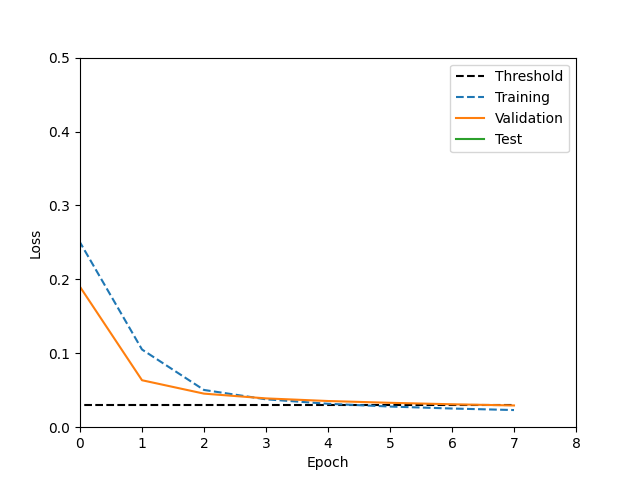

Done training.78/1178          
Recordings left: 250/250


<IPython.core.display.Javascript object>


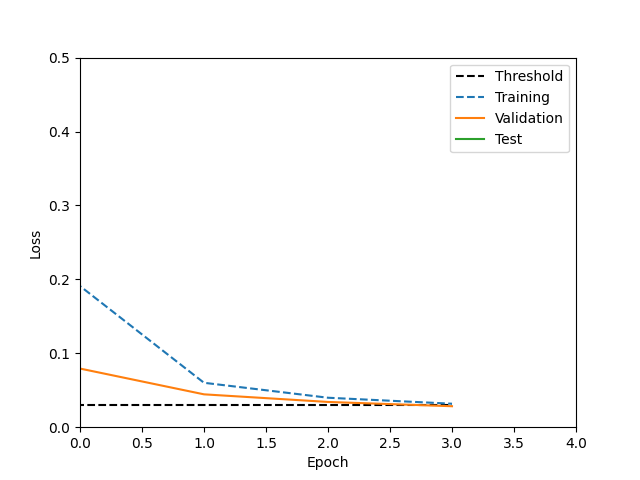

Done training.91/1291          
traking done: recording 249/249           
traking done: recording 250/250           
{'der': 4.86, 'eer': 13.45, 'dcf': 0.8486}
{'der': 29.39, 'eer': 23.33, 'dcf': 0.9876}
{'der': 17.125, 'eer': 18.39, 'dcf': 0.9181}
ivectors 128 20 1
Recordings left: 249/249


<IPython.core.display.Javascript object>


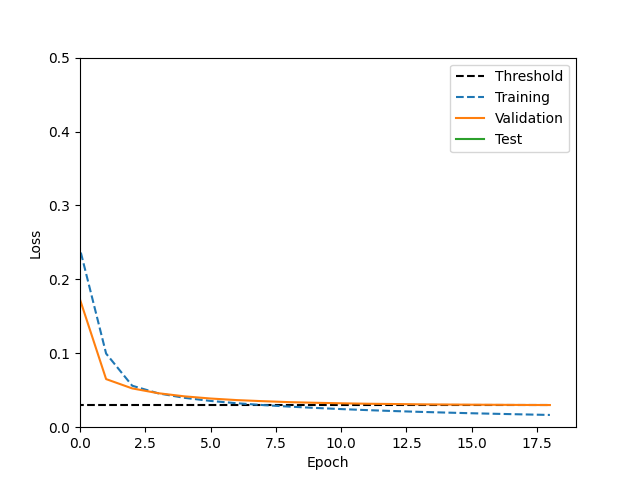

Done training.38/1138          
Recordings left: 250/250


<IPython.core.display.Javascript object>


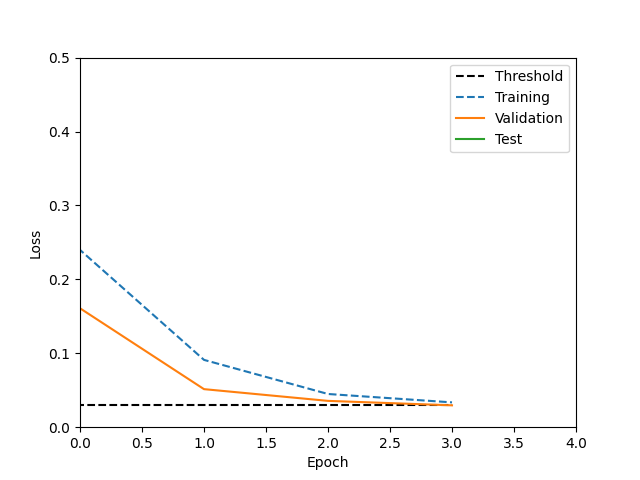

Done training.11/1411          
traking done: recording 249/249           
traking done: recording 250/250           
{'der': 9.43, 'eer': 11.83, 'dcf': 0.7946}
{'der': 31.46, 'eer': 16.83, 'dcf': 0.9999}
{'der': 20.445, 'eer': 14.329999999999998, 'dcf': 0.89725}
ivectors 128 20 2
Recordings left: 249/249


<IPython.core.display.Javascript object>


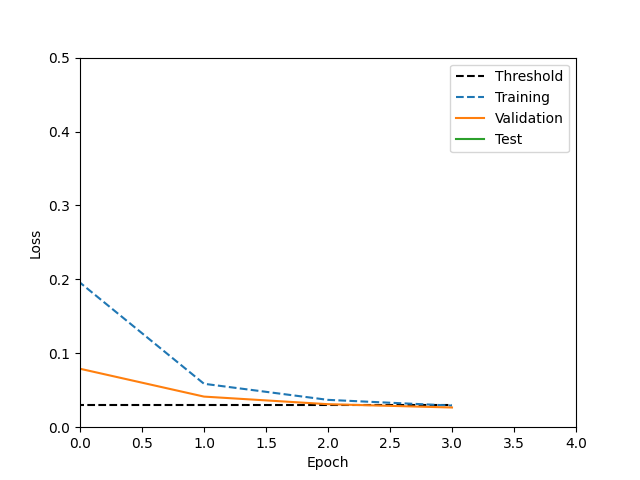

Done training.61/1361          
Recordings left: 250/250


<IPython.core.display.Javascript object>


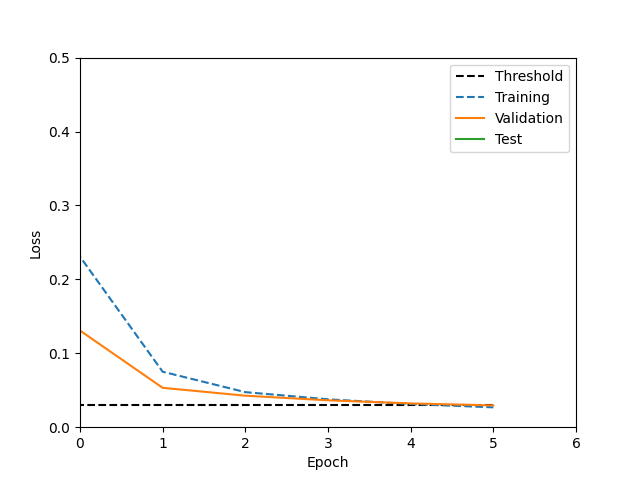

Done training.63/1263          
traking done: recording 249/249           
traking done: recording 250/250           
{'der': 5.17, 'eer': 8.406, 'dcf': 0.7434}
{'der': 5.89, 'eer': 15.44, 'dcf': 0.9944}
{'der': 5.529999999999999, 'eer': 11.923, 'dcf': 0.8689}


In [11]:
for vector in ['ivectors']:
    vector_length = 128 if vector == 'ivectors' else 128
    for models_generation_length in [20]:
        for i in range(3):
            print(vector, vector_length, models_generation_length, i)
            a_trainer = Trainer()
            a_net = a_trainer.get_net(balance_segments(a_recordings_segments,maximum_speakers_length,1,False),
                                      vector = vector,
                                      vector_length = vector_length,
                                      models_container_length = models_container_length,
                                      models_container_include_zeros = models_container_include_zeros,
                                      models_container_include_overlaps = models_container_include_overlaps,
                                      models_generation_lengths = [models_generation_length],
                                      models_generation_selection = models_generation_selection,
                                      balance_segments_selection = balance_segments_selection,
                                      batch_size = batch_size)
            b_trainer = Trainer()
            b_net = b_trainer.get_net(balance_segments(b_recordings_segments,maximum_speakers_length,1,False),
                                      vector = vector,
                                      vector_length = vector_length,
                                      models_container_length = models_container_length,
                                      models_container_include_zeros = models_container_include_zeros,
                                      models_container_include_overlaps = models_container_include_overlaps,
                                      models_generation_lengths = [models_generation_length],
                                      models_generation_selection = models_generation_selection,
                                      balance_segments_selection = balance_segments_selection,
                                      batch_size = batch_size)
            
            test_id = '20200611_callhome_2' + vector + '_' + str(models_generation_length) + '_' + str(i)
            
            a_results = tracking_tester(a_recordings_test_segments,
                                        scoring_function = lambda vector, models_container: net_selector(vector, models_container, b_net),
                                        groundtruth_filepath = a_groundtruth,
                                        groundtruth_valid_speakers_ids = ['A', 'B'],
                                        vector = vector,
                                        models_container_length = models_container_length,
                                        models_container_include_overlaps = models_container_include_overlaps,
                                        models_generation_length = models_generation_length,
                                        models_generation_selection = models_generation_selection,
                                        save_dir = 'batch/' + test_id + '_a')
        

            b_results = tracking_tester(b_recordings_test_segments,
                                        scoring_function = lambda vector, models_container: net_selector(vector, models_container, a_net),
                                        groundtruth_filepath = b_groundtruth,
                                        groundtruth_valid_speakers_ids = ['A', 'B'],
                                        vector = vector,
                                        models_container_length = models_container_length,
                                        models_container_include_overlaps = models_container_include_overlaps,
                                        models_generation_length = models_generation_length,
                                        models_generation_selection = models_generation_selection,
                                        save_dir = 'batch/' + test_id + '_b')
            
            print(a_results)
            print(b_results)
            output_der = (a_results['der'] + b_results['der']) / 2
            output_eer = (a_results['eer'] + b_results['eer']) / 2
            output_dcf = (a_results['dcf'] + b_results['dcf']) / 2
            results = { 'der': output_der, 'eer': output_eer, 'dcf': output_dcf }
            print(results)
            
            file = open('batch/results.csv', 'a')
            file.write(test_id + ', ' + json.dumps(a_results) + ', ' + json.dumps(b_results) + ', ' + json.dumps(results) + '\n')
            file.close()